On importe dans un premier temps les modules nécessaires :


In [1]:
import csv
import sys
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt

     |████████████████████████████████| 12.4 MB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 67 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 20.2 MB 43.2 MB/s eta 0:00:01    |████████▎                       | 5.2 MB 43.2 MB/s eta 0:00:01


Je créé la fonction d'extraction avec comme paramètre le nom de fichier que j'ai préalablement inséré au même niveau que ce document jupyter

In [2]:
def extractionDonnees(nomFichier):
    """Cette fonction récupère les données d'un fichier csv et renvoie un dictionnaire :
    La liste des descripteurs et la liste de toutes les données"""
    nomDuFichier = nomFichier
    if nomFichier[-4:]!=".csv":
        nomDuFichier+=".csv"
    fichier = open(nomDuFichier,"r",encoding="utf-8")
    extraction=csv.DictReader(fichier,delimiter=";")
    listeJoueurs=[]
    for ligne in extraction:
        listeJoueurs.append(dict(ligne))
    return listeJoueurs

In [3]:
Joueurs=extractionDonnees("JoueursTop14.csv")


Je crée une fonction qui va me permettre de n'extraire qu'une partie des joueurs (ceux d'un même club). Si le deuxième paramètre vaut "tous", alors il prendra tous les joueurs.

In [4]:
def extraireEquipe(data,equipe):
    """de l'ensemble des listes, on extrait seulement celles d'une équipe
    Parmi les équipes, on trouve "Agen", "Bayonne", "Bordeaux", "Brive", "Castres", "Clermont",
    "La Rochelle", "Lyon", "Montpellier", "Paris", "Pau", Racing92", "Toulon" et "Toulouse"
    On peut aussi écrire "tous" pour avoir tous les joueurs du top 14"""
    return [el for el in data if (el['Equipe'] == equipe or equipe.lower() == "tous")]


In [5]:
Toulouse = extraireEquipe(Joueurs,"Toulouse")
Clermont = extraireEquipe(Joueurs,"Clermont")

In [6]:
def representation(data):
    """data est une liste de joueurs avec leurs caractéristiques.
    On extrait leur taille et poids puis on représente ces données dans un repère
    (une couleur par type de poste la position étant déterminée par la liste des descripteurs)
    Les types de postes sont "Avant", "2ème ligne", "3ème ligne", "Demi", "Trois-Quarts" et "Arrière" """
    dictCouleurs = {"Avant":"tab:blue", "2ème ligne":"tab:red", "3ème ligne":"tab:green", "Demi":"tab:purple", "Trois-Quarts":"tab:brown", "Arrière":"tab:orange"}
    dictMarkers = {"Avant":"x", "2ème ligne":"+", "3ème ligne":"1", "Demi":".", "Trois-Quarts":"*", "Arrière":"^"}
    fig = plt.figure()
    listLabel = []
    for joueur in data:
        #Ce qui suit sert juste à afficher les labels
        if joueur["Type poste"] in listLabel:
            plt.plot(int(joueur["Taille (en cm)"]), int(joueur["Poids (en kg)"]), color=dictCouleurs[joueur["Type poste"]],marker=dictMarkers[joueur["Type poste"]])
        else :
            plt.plot(int(joueur["Taille (en cm)"]), int(joueur["Poids (en kg)"]), color=dictCouleurs[joueur["Type poste"]],marker=dictMarkers[joueur["Type poste"]],label=joueur["Type poste"])
            listLabel.append(joueur["Type poste"])
    #Cette partie sert juste à créer le nom du fichier
    equipe = [joueur["Equipe"] for joueur in data]
    if(equipe.count(equipe[0]) == len(equipe)):
        #c'est que tous les joueurs sont d'une même équipe,
        nomEquipe = data[1]["Equipe"]
    else :
        nomEquipe = "top14"
    plt.xlabel("Taille (en cm)")
    plt.ylabel("Poids (en kg)")

    plt.legend(title=nomEquipe,markerscale = 1.2,frameon = True)
    plt.savefig(nomEquipe+".png")
    plt.show()

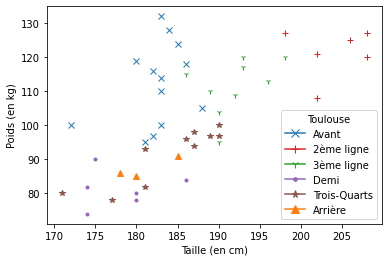

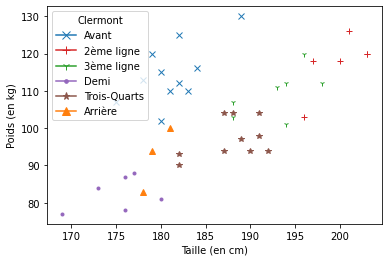

In [7]:
representation(Toulouse)
representation(Clermont)

Dans notre contexte, on souhaite déterminer quel type de poste peut prendre un joueur connaissant sa taille
et son poids.
<h4 style='color:blue; font-weight:bold'>1. Le principe de l’algorithme en langage courant</h4>
On dispose d’un ensemble de données, d’une fonction distance et d’un entier k.
Chaque donnée contient deux types d’informations :
<ul>
    <li> deux données numériques destinées à la comparaison de deux éléments de l’ensemble;</li>
    <li> un troisième critère destiné à la classification d’un élément.</li>
</ul>
<h5> (a) Dans notre exemple des joueurs de rugby, que sont ces types d’informations ?</h5>

<h5> (b) Fonction distance</h5> 

In [8]:
from math import sqrt
def distance(x1,y1,x2,y2):
    """distance euclidienne entre les points de coordonnées (x1;y1) et (x2;y2)"""
    return sqrt((x2-x1)**2+(y2-y1)**2)

<h5> (c) Le principe de l’algorithme</h5> 
<ol>
    <li>Parcourir la liste de tous les joueurs de l'équipe choisie (c'est une liste de dictionnaires dans notre exemple) ;</li>
    <li>Calculer pour chacun des joueurs la "distance" (en termes de taille et poids) avec le nouveau joueur ;</li>
    <li>Récupérer les k joueurs les plus proches en termes de distance ;</li>
    <li>Dans cette liste de k joueurs, identifier le critère de "type de poste" le plus souvent présent et l'affecter au nouveau joueur.</li>
</ol>

<h5> (d) Avec le tableur</h5> 
Le problème avec la formule proposée c'est qu'en la recopiant vers le bas, les références I2 et J2 évoluent et les formules recopiées créent alors des erreurs.<br/>
Il faut donc fixer le numéro de ligne des références I2 et J2 : <br/>
=RACINE((F2-I<span style='color:blue;'>\$</span>2)^2+(G2-J<span style='color:blue;'>\$</span>2)^2)

<h4 style='color:blue; font-weight:bold'>2. Traduction en python</h4>

In [9]:
#La fonction ci-dessous recherche le type de poste le plus courant dans la liste des données extraites (chaque donnée est un dictionnaire - correspondant aux caractéritiques d'un joueur)
#Dans cette fonction, je ne parcours qu'une et une seule fois la liste des k dictionnaires
def rechercheTypePoste(data):
    """dans data, on cherche le type de poste le plus souvent présent (type poste étant d'index 3 dans chaque élément de data)"""
    listePoste = [] #c'est la liste des postes déjà trouvés au fur et à mesure qu'on parcourt data
    occurrencePoste = {} #occurencePoste sera un dictionnaire avec pour clés chaque type de poste présent dans data
    for elt in data:
        if elt["Type poste"] in listePoste:
            occurrencePoste[elt["Type poste"]]+=1
        else :
            listePoste.append(elt["Type poste"])
            occurrencePoste[elt["Type poste"]] = 1
    #Je parcours la liste des postes pour savoir le plus présent
    typePoste=''
    occurrence=0
    for poste in listePoste:
        if occurrencePoste[poste]>occurrence:
            typePoste=poste
            occurrence=occurrencePoste[poste]
    return typePoste

#Voici une autre fonction renvoyant le même résultat. Cette fois-ci j'utilise la fonction count qui parcourt la liste à chaque appel (donc cela demandera un peu plus de temps de traitement - mais cela restera insignifiant pour nous)
def autreRechercheTypePoste(data):
    listePoste = [elt["Type poste"] for elt in data] #je me contente de la liste des postes des éléments de data
    Occu = 0 # occurence du type de poste le plus souvent présent (initialisé à 0)
    for poste in listePoste:
        effectif = lstClasse.count(poste)  #cette variable me permet de n'appeler la méthode count qu'une seule fois (penser que l'appel de cette fonction oblige à parcourir toute la liste)
        if effectif>Occu:
            Occu=effectif
            C=poste
    return poste

In [10]:
def classification(k,data,taille,poids):
    """une série de données étant fournies, on souhaite extraire la classe type de poste d'un joueur dont la taille et le poids sont fournis
    data est une liste de dictionnaires de clés : 'Equipe', 'Nom', 'Poste', 'Type poste', 'Date de naissance', 'Taille', 'Poids'
    On utilise l'algorithme des k plus proches voisins avec k premier paramètre de cette fonction
    Cet algorithme utilise un tri des données"""
    knn = sorted(data, key=lambda x:distance(int(x["Taille (en cm)"]),int(x["Poids (en kg)"]),taille,poids))[:k] #on ordonne les éléments de la liste data suivant la distance (key) et on en prend que les k premiers éléments
    return rechercheTypePoste(knn)

In [11]:
(classification(7, Toulouse, 185, 98), 
classification(7, Toulouse, 185, 112), 
classification(7, Toulouse, 175, 91), 
classification(7, Toulouse, 180, 90))

('Trois-Quarts', 'Avant', 'Demi', 'Arrière')

Deuxième algorithme plus efficace car on ne passe plus par le rangement des valeurs dans l'ordre

In [12]:

def classificationEfficace(k,data,taille,poids):
    """une série de données étant fournies, on souhaite extraire la classe type de poste d'un joueur dont la taille et le poids sont fournis
    data est une liste de dictionnaires de clés : 'Equipe', 'Nom', 'Poste', 'Type poste', 'Date de naissance', 'Taille', 'Poids'
    On utilise l'algorithme des k plus proches voisins avec k premier paramètre de cette fonction
    Cet algorithme ne range pas les données dans l'ordre"""
    extraction = [] # cette liste contiendra un tuple où le premier élément sera la ligne d'un joueur et le deuxième élément la distance par rapport au nouveau joueur (cela évite de la recalculer)
    for joueur in data:
        newDist = distance(int(joueur['Taille (en cm)']),int(joueur["Poids (en kg)"]),taille,poids)
        aPlacer = len(extraction)<k or newDist<extraction[-1][1]    #au premier passage, extraction est vide, mais extraction[-1] n'est pas évalué donc ça ne plante pas
        #ce booléen aPlacer me permet de déterminer si j'ajoute le joueur à ma liste des k plus proches voisins
        if aPlacer:
            #On met joueur dans la liste extraction
            #On le met cependant à sa place dans la liste ordonnée par les distances
            if(len(extraction)==0):
                extraction.append((joueur, newDist)) #J'ajoute un tuple, donc j'ai besoin de ces deux parenthèses
            else:
                if(len(extraction)==k):
                    extraction.pop() #avant d'ajouter un nouvel élément, on enlève le dernier
                pos=len(extraction)
                while (pos>=1 and newDist<extraction[pos-1][1]):
                    pos-=1
                extraction.insert(pos,(joueur,newDist)) #l'élément est alors inséré à sa place (dans l'ordre croissant de la distance)
    knn = [el[0] for el in extraction]
    return rechercheTypePoste(knn)

In [13]:
(classificationEfficace(7, Toulouse, 185, 98), 
classificationEfficace(7, Toulouse, 185, 112), 
classificationEfficace(7, Toulouse, 175, 91), 
classificationEfficace(7, Toulouse, 180, 90))

('Trois-Quarts', 'Avant', 'Demi', 'Arrière')